# Converting image to Hough space and calculating the number of lines

Some inspiration and logic was taken from https://github.com/FienSoP.

In [333]:
import os 
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

In [334]:
%matplotlib inline

## Load sample image

In [335]:
# Helper functions

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def load_data(image_name):    
    img = mpimg.imread(image_name)
    img = rgb2gray(img)
    
    return img

In [336]:
sample_image_name = 'marker_cut_rgb_512.png'

In [337]:
sample_image = load_data(sample_image_name)
sample_image_arr = np.array(sample_image)

## Hough space math background

A line in Cartesian form could be expressed in the equation:

*y = mx + b*

where: 

m = gradient or slope of the line (rise/run)   
b = y-intercept

![Example of two points with various intersections](hough_mb_parameter_space.png)

If we have two example points, for each point we can set different values of *m* and therefore obtain different intersections, and we can compute corresponding *b* values.

All points on a line in image space intersect at a common point in parameter space. This common point *(m, b)* represents the line in image space.
Unfortunately, the slope, *m*, is undefined when the line is vertical (division by 0!).
To overcome this, we use another parameter space, the hough space.

## Polar coordinate system

A line in Polar coordinate system could be expressed in the equation:

*ρ = x cos θ + y sin θ*

where:

*ρ (rho)* = distance from origin to the line. [-max_dist to max_dist].
          max_dist is the diagonal length of the image.  
*θ* = angle from origin to the line. [-90° to 90°]


## Algorithm steps

1. **Corner or edge detection**. We can use **Canny, Sobel or Adaptive Thresholding algorithm**. The result of this step is binary or grey image with zeros indicating non-edges and ones indicating edges. The result is now interpreted as our input image

2. **Rho range and Theta range creation.** ρ ranges from *-max_dist* to *+max_dist* where *max_dist* is the diagonal length of the input image (the number of diagonal entries in image matrix). θ ranges from *-90∘ to 90∘*. 

3. **Hough accumulator of θ vs ρ**. Is a 2D array with the number of rows equal to the number of ρ values and the number of columns equal to number of θ values.

4. **Accumulator voting**. For each of the edge points and for each of θ we find the nearest corresponding ρ value and increment it index in the accumulator. Each element in our accumulator matrix tells how many pixels contributed votes for line candidate with tuple of parameters (ρ, θ)

5. **Peak search**. Maximum values in the accumulator matrix indicate parameters of most probable lines in the image. Peaks could be found by applying some threshold.

## Convolution operator

Convolution is a simple mathematical operation which is fundamental to many common image processing operators. Convolution provides a way of multiplying together two arrays of numbers, generally of different sizes, but of the same dimensionality, to produce a third array of numbers of the same dimensionality. 

This can be used in image processing to implement operators whose output pixel values are simple linear combinations of certain input pixel values.

The implementation is based on cpython implementation and the main inspiration/logic flow was taken from there.

In [338]:
def convolve_kernel(matrix, kernel):
    '''
    Performs a 2-d convolution between the
    input matrix(x,y) and kernel(s,t)
    
    Returns an convolved image(z, g)
    '''
    
    # Calculate the output image size
    
    x_max = matrix.shape[0]
    y_max = matrix.shape[1]
    
    # Get the kernel size
    
    s_max = kernel.shape[0]
    t_max = kernel.shape[1]
    
    s_mid = s_max // 2
    t_mid = t_max // 2
    
    # Define the size of output image
    
    z_max = x_max + 2 * s_mid
    g_max = y_max + 2 * t_mid
    
    # Create empty array which will be the output image
    
    output = np.zeros([z_max, g_max], dtype = np.float32)
    
    for z in range(z_max):
        for g in range(g_max):
            
            # Calculate the z,g pixel value for output image
            
            # Compute range for kernel values
            s_from_range = max(s_mid - z, -s_mid)
            s_to_range = min((z_max - z) - s_mid, s_mid + 1)
            
            t_from_range = max(t_mid - g, -t_mid)
            t_to_range = min((g_max - g) - t_mid, t_mid + 1)
            
            value = 0
            
            for s in range(s_from_range, s_to_range):
                for t in range(t_from_range, t_to_range):
                    x = z - s_mid + s
                    y = g - t_mid + t
                    value += kernel[s_mid - s, t_mid - t] * matrix[x, y]
                    
            output[z, g] = value
            
    return output        

## Canny Edge Detector (CED)

*The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works (C)*

The general algorithm goes in five steps:

- Noise reduction
- Image gradient calculation
- Non-maximum suppression (*optional*)
- Double threshold (*optional*)
- Edge tracking


The algorithm is based on grayscale images, so the input image should be grayscale

### Noise reduction

Since this algorithm is based on gradient calculation it is very sensitive to image noise and the **noise reduction** stage is crucial.
The easiest approach is to add Gaussian blur to the image to smooth it. We need to select the kernel size of the Gaussian Filter, which will set the amount of blur.

![Gaussian Kernel formula](gaussian_kernel_formula.png)

In [339]:
def gaussian_kernel(kernel_size, sigma = 1):
    '''
    Create a Gaussian Kernel of given size
    for applying blur to image
    '''
    
    kernel_size = int(kernel_size) // 2
    x, y = np.mgrid[-kernel_size:kernel_size+1, -kernel_size:kernel_size+1] 
    norm = 1 / (2.0 * np.pi * sigma**2)
    kernel = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * norm
    
    return kernel

### Gradient Calculation

Gradient calculation detects the edge intensity and direction by calculating the gradient of the whole image using edge detection operators.

*Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)*

After image smoothing phase the *Ix* and *Iy* are calculated. It could be implemented with Sobel Kernels *Kx* and *Ky*.

![Sobel Filters](sobel_filters.png)

![Magnitude](magnitude.png)

In [341]:
def sobel_filters(image):
    '''
    Calculates the gradient of the image by
    Sobel operators (edge detection operators)
    
    And returns the matrix G and array of thetas
    '''
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(image, Kx)
    Iy = ndimage.filters.convolve(image, Ky)
    
    g = np.hypot(Ix, Iy)
    g = g / g.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (g, theta)

### Non-maximum suppression

This approach is used to have thin edges in our images. Non-thin edges could be encountered due to various reasons - one of them is blur. The princimple is quite simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with maximum value in the edge directions.

The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed.

The algorithm flow:

- Create zeros matrix of the same size as the original gradient matrix
- Identify the edge direction based on the angle value from the matrix of angles
- Check if the pixels in the same direction of the current processed pixel have higher intensity

In [342]:
def non_max_suppression(image, diagonal):
    '''
    Inputs an image and matrix of angles
    and outputs a matrix of thinned edges
    '''
    
    m, n = image.shape
    
    # Create zeros matrix of gradient size
    zer_proc = np.zeros((m,n), dtype = np.int32)
    
    # Calculate angles of the pixels
    angle = diagonal * 180. / np.pi
    
    # Supress zero angles
    angle[angle <0] += 180
    
    for i in range(1, m-1):
        for j in range(1, n-1):
            try :
                # Get the values of next and previous pixel in direction
                next_pixel = image[i, j+1]
                previous_pixel = image[i, j-1]
                
                #0°
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    next_pixel = image[i, j+1]
                    previous_pixel = image[i, j-1]
                    
                #45°
                elif (22.5 <= angle[i,j] < 67.5):
                    next_pixel = image[i+1, j-1]
                    previous_pixel = image[i-1, j+1]
                    
                #90°
                elif (67.5 <= angle[i,j] < 112.5):
                    next_pixel = image[i+1, j]
                    previous_pixel = image[i-1, j]
                    
                #135°
                elif (112.5 <= angle[i,j] < 157.5):
                    next_pixel = image[i-1, j-1]
                    previous_pixel = image[i+1, j+1]

                    
                if (image[i,j] >= next_pixel) and (image[i,j] >= previous_pixel):
                    zer_proc[i,j] = image[i,j]
                else:
                    zer_proc[i,j] = 0
                
            except IndexError:
                pass
            
    return zer_proc
                

### Double threshold

The main idea of double threshold is to identify three types of pixels: strong, weak and non-relevant. 

- **Strong pixels** - have very high intensity, compared to others, and will contributed to edge detection.
- **Weak pixels** - are something in mediocre of strong and non-relevant pixels. 
- **Non-relevant** - have very low intensity and therefore won't contribute to edge detection


So what is the idea of **double** threshold? We set two hyperparameters - **high threshold** and **low threshold**. 

- Pixels, that have intensity higher than high threshold are considered **strong**
- Pixels, that have intensity lower than low threshold are considered **non-relevant**
- All other pixels are considered **weak**

In [353]:
def double_threshold(image, low_threshold_ratio, high_threshold_ratio):
    '''
    Applies double threshold algorithm to image with
    given ratio and outputs processed image, weak pixels and strong pixels
    Weak pixels and strong pixels could be used in Hysteresis edge tracking 
    or ommited
    '''
    
    # Calculate the threshold intensity values for image
    high_threshold = image.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    
    # Create resulting matrix - the same size as previously processed image
    m,n = image.shape
    res_matrix = np.zeros((m,n), dtype = np.int32)
    
    # Create matrices for weak and strong pixels
    weak_pixels = np.int32(25)
    strong_pixels = np.int32(255)
    
    # Find the indexes for corresponding pixels
    i_str, j_str = np.where(image >= high_threshold)
    i_low, j_low = np.where(image < low_threshold)
    i_weak, j_weak = np.where((image <= high_threshold) & (image >= low_threshold)) 
    
    res_matrix[i_str, j_str] = strong_pixels
    res_matrix[i_weak, j_weak] = weak_pixels
    
    return (res_matrix, weak_pixels, strong_pixels)   

### Hysteresis edge tracking

The final improvement step called the **Hysteresis** is used to transform weak pixels into strong ones if there are at least one strong pixel near the current processed weak one.

![Hysteresis](hysteresis.png)

In [345]:
def hysteresis(image, weak_pixels, strong_pixels):
    '''
    Gets an input image and checks pixel-by-pixel
    all surrounding pixels to be strong
    
    Outputs an converted image
    '''
    
    m,n = image.shape
    
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            if(image[i,j] == weak_pixels):
                try:
                    # Check all possible options for surrounding pixels to be strong
                    if ((image[i+1, j-1] == strong_pixels) or 
                        (image[i+1, j] == strong_pixels) or 
                        (image[i+1, j+1] == strong_pixels) or 
                        (image[i, j-1] == strong_pixels) or 
                        (image[i, j+1] == strong_pixels) or 
                        (image[i-1, j-1] == strong_pixels) or 
                        (image[i-1, j] == strong_pixels) or
                        (image[i-1, j+1] == strong_pixels)):
                         
                        image[i, j] = strong_pixels
                    else:
                        image[i, j] = 0
                except IndexError:
                    pass
                
    return image  

In [346]:
def HoughLines(image, angle_step=1, value_threshold=5):
    '''
    Takes an input image as numpy 2d-array
    angle_step is the step between angles of thetas (-90, +90)
    value_threshold is the value of pixels to be detected as edges
    NOTE: It's better to use this method after some preliminary image
    pre-processing
    returns accumulator - a numpy 2d-array of hough trans. accumulation
    rhos - array of rho values of the lines
    thetas - array of angles computed
    '''
    
    # Rho range and Theta range creation
    
    width, height = image.shape
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    
    max_distance = int(np.ceil(np.sqrt(width * width + height * height)))
    rhos = np.linspace(-max_distance, max_distance, max_distance * 2)

    # Calculate the sinus and cosinus of theta values
    # Will produce a numpy array for corresponding cos and sin
    
    theta_cos = np.cos(thetas)
    theta_sin = np.sin(thetas)

    # Create Hough accumulator
    
    accumulator = np.zeros((2 * max_distance, len(thetas)))
    
    # Edge indexes
    
    edges = image > value_threshold
    y_id, x_id = np.nonzero(edges)  
    
    
    # Accumulator voting
    
    xcosthetas = np.dot(x_id.reshape((-1,1)), theta_cos.reshape((1,-1)))
    ysinthetas = np.dot(y_id.reshape((-1,1)), theta_sin.reshape((1,-1)))
    
    rhosmat = np.round(xcosthetas + ysinthetas) + max_distance
    rhosmat = rhosmat.astype(np.int16)
    
    for i in range(len(thetas)):
        rhos, counts = np.unique(rhosmat[:,i], return_counts=True)
        accumulator[rhos,i] = counts
        
    return thetas, rhos, accumulator

In [347]:
# Method to visualize hough lines

def plot_hough_lines(image, trans_image, accumulator, rhos, thetas):
    
    # Create output figure
    
    fig, ax = plt.subplots(1,3, figsize = (12,8))
    
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    
    ax[1].imshow(trans_image, cmap=plt.cm.gray)
    ax[1].set_title('Hough input image')
    
    ax[2].imshow(accumulator, cmap='jet', extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_title('Hough transformation')
    ax[2].set_xlabel('Angles (degrees)')
    ax[2].set_ylabel('Distance (pixels)')
    
    plt.show()

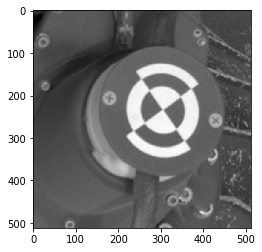

In [348]:
# Original image

imgplot = plt.imshow(sample_image_arr, cmap = 'gray')

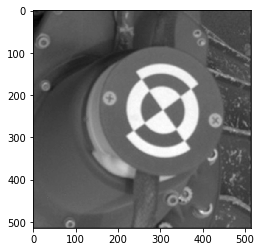

In [350]:
# Smooth the sample image

smoothed_image = convolve_kernel(sample_image_arr, gaussian_kernel(3))
imgplot = plt.imshow(smoothed_image, cmap = 'gray')

We see that the edges of our marker become more smooth and the edges of the the screws become smoother as well.

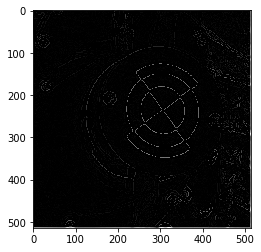

In [351]:
# Find the gradients and apply non-max suppression

grad_matrix, theta_matrix = sobel_filters(smoothed_image)
non_max_image = non_max_suppression(grad_matrix, theta_matrix)
imgplot = plt.imshow(non_max_image, cmap = 'gray')

After non-max suppression and Sobel gradients the image became very low-saturated.

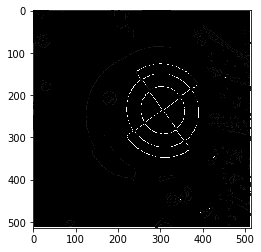

In [354]:
# Apply double thresholding

threshold_image, weak_pixels, strong_pixels = double_threshold(non_max_image, 0.3, 0.4)

imgplot = plt.imshow(threshold_image, cmap = 'gray')

Double thresholding helped us to detect strong and weak pixels on the image.

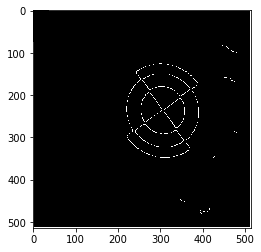

In [355]:
# Apply hysteresys search

hysteresys_img = hysteresis(threshold_image, weak_pixels, strong_pixels)

imgplot = plt.imshow(hysteresys_img, cmap = 'gray')

Hysteresis algorithm helped us to restore some of the necessary pixels and the lines of the image are now less intermittent.

We can see that image noise was decreased and the lines are visible much better now.

In [291]:
# Apply Hough space algorithm

thetas, rhos, accumulator = HoughLines(hysteresys_img, angle_step = 1, value_threshold = 5)

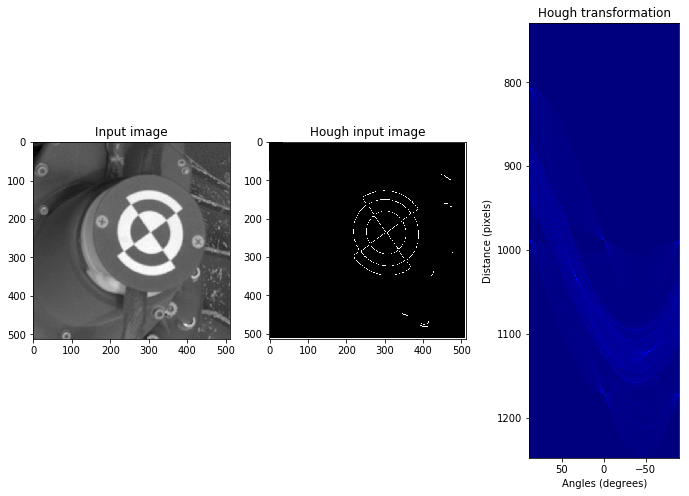

In [292]:
plot_hough_lines(sample_image, hysteresys_img, accumulator, rhos, thetas)

Main inspiration was taken from http://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm about the logic and visualization.